# Proyecto 3 Minería de Datos
## Integrantes:
- Carlos Valladares, 221164
- Julio Lemus,
- Hugo Rivas,
- Alexis Mesias

### Carga de datos y unión de tablas

In [8]:
import pandas as pd

# Asegúrate de que los archivos están en la carpeta 'data/'
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")

# Convertir fechas a formato datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Calcular el tiempo de entrega en días
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Unir las tablas necesarias
df = orders.merge(order_items, on='order_id', how='left') \
           .merge(products, on='product_id', how='left') \
           .merge(reviews, on='order_id', how='left') \
           .merge(customers, on='customer_id', how='left')

# Mantener solo las columnas clave
df = df[['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_time',
         'price', 'freight_value', 'review_score', 'product_category_name',
         'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']]

print("✅ df creado correctamente con shape:", df.shape)


✅ df creado correctamente con shape: (114092, 12)


### Análisis Exploratorio de Datos (EDA)

            order_purchase_timestamp  delivery_time          price  \
count                         114092  110839.000000  113314.000000   
mean   2017-12-31 03:25:40.890754816      12.012414     120.478701   
min              2016-09-04 21:15:19       0.000000       0.850000   
25%       2017-09-12 21:26:59.500000       6.000000      39.900000   
50%       2018-01-18 20:36:17.500000      10.000000      74.900000   
75%    2018-05-04 00:24:31.249999872      15.000000     134.900000   
max              2018-10-17 17:30:18     209.000000    6735.000000   
std                              NaN       9.445470     183.279678   

       freight_value   review_score  product_weight_g  product_length_cm  \
count  113314.000000  113131.000000     113296.000000      113296.000000   
mean       19.979428       4.016998       2091.915037          30.162495   
min         0.000000       1.000000          0.000000           7.000000   
25%        13.080000       4.000000        300.000000          18

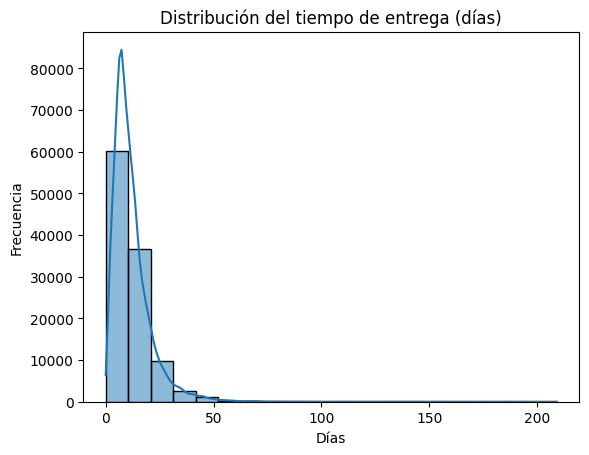

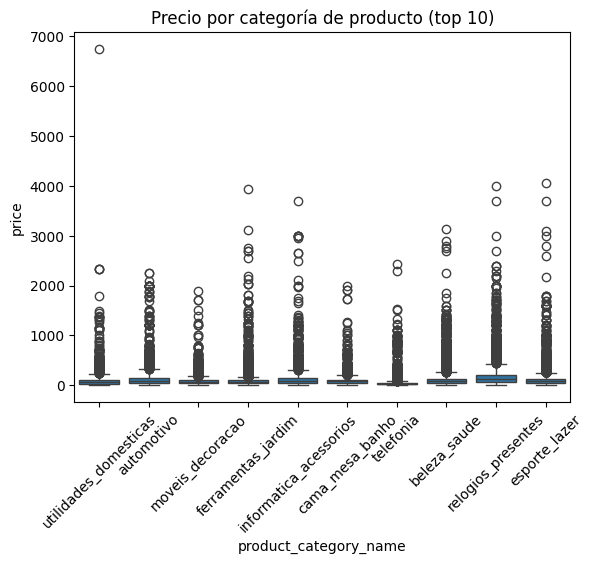

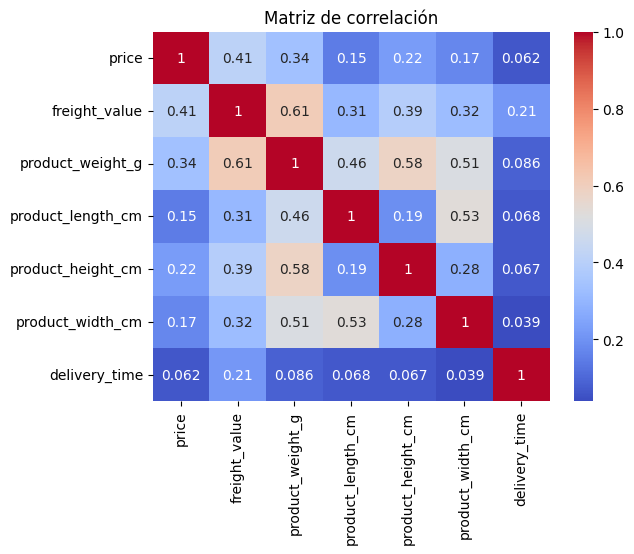

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Resumen estadístico
print(df.describe())

# Histograma del tiempo de entrega
sns.histplot(df['delivery_time'].dropna(), bins=20, kde=True)
plt.title("Distribución del tiempo de entrega (días)")
plt.xlabel("Días")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot del precio por categoría
top_cats = df['product_category_name'].value_counts().head(10).index
sns.boxplot(data=df[df['product_category_name'].isin(top_cats)],
            x='product_category_name', y='price')
plt.xticks(rotation=45)
plt.title("Precio por categoría de producto (top 10)")
plt.show()

# Matriz de correlación
num_vars = ['price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'delivery_time']
corr = df[num_vars].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

### Preprocesamiento del Dataset

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# ======== 1. PREPROCESAMIENTO GENERAL ========
df_model = df.dropna(subset=[
    'price', 'delivery_time', 'review_score', 'product_category_name',
    'freight_value', 'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm'
]).copy()

# Codificación
le = LabelEncoder()
df_model['product_category_encoded'] = le.fit_transform(df_model['product_category_name'])
df_model['satisfaccion'] = df_model['review_score'].apply(lambda x: 1 if x >= 4 else 0)

features = ['price', 'freight_value', 'product_weight_g', 'product_length_cm',
            'product_height_cm', 'product_width_cm', 'product_category_encoded']

X = df_model[features]
y_reg = df_model['delivery_time']
y_clf = df_model['satisfaccion']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# ======== 2. REGRESIÓN ========
X_train_sample = X_train_reg.sample(3000, random_state=42)
y_train_sample = y_train_reg.loc[X_train_sample.index]

models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
}

print("📊 REGRESIÓN")
for name, model in models_reg.items():
    model.fit(X_train_sample, y_train_sample)
    y_pred = model.predict(X_test_reg)

    print(f"\n🔍 {name}")
    print("MAE:", round(mean_absolute_error(y_test_reg, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 2))
    print("R²:", round(r2_score(y_test_reg, y_pred), 4))

# ======== 3. CLASIFICACIÓN ========
X_train_clf_sample = X_train_clf.sample(5000, random_state=42)
y_train_clf_sample = y_train_clf.loc[X_train_clf_sample.index]

X_test_clf = X_test_clf.dropna()
y_test_clf = y_test_clf.loc[X_test_clf.index]

models_clf = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42)
}

print("\n📊 CLASIFICACIÓN")
for name, model in models_clf.items():
    model.fit(X_train_clf_sample, y_train_clf_sample)
    y_pred = model.predict(X_test_clf)

    print(f"\n🔍 {name}")
    print("Accuracy:", round(accuracy_score(y_test_clf, y_pred), 4))
    print("Precision:", round(precision_score(y_test_clf, y_pred), 4))
    print("Recall:", round(recall_score(y_test_clf, y_pred), 4))
    print("F1-score:", round(f1_score(y_test_clf, y_pred), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test_clf, y_pred))


📊 REGRESIÓN

🔍 Linear Regression
MAE: 6.01
RMSE: 8.94
R²: 0.0479

🔍 Random Forest
MAE: 5.83
RMSE: 8.87
R²: 0.0624

📊 CLASIFICACIÓN

🔍 Logistic Regression
Accuracy: 0.7679
Precision: 0.7685
Recall: 0.999
F1-score: 0.8687
Confusion Matrix:
 [[    2  5019]
 [   16 16659]]

🔍 Random Forest
Accuracy: 0.7464
Precision: 0.7781
Recall: 0.9373
F1-score: 0.8503
Confusion Matrix:
 [[  563  4458]
 [ 1045 15630]]


### Exportar el dataset preprocesado

In [11]:
df_model.to_csv("olist_dataset_modelado.csv", index=False)
print("✅ Dataset exportado exitosamente como 'olist_dataset_modelado.csv'")

✅ Dataset exportado exitosamente como 'olist_dataset_modelado.csv'
